In [4]:
from daqx.util import createDevice
import time
import numpy as np
from matplotlib import pyplot as plt

### General DAQ setup

In [5]:
daq = createDevice('mcc',0)
daq.config_ai(0,1)
daq.config_ao(0,1)

In [6]:
def foo(eventdata,*arg,**kwarg):
    #print('callback executed')
    if eventdata['event'] == 'samplesAcquiredFcn':
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    else:
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called with arg = {"".join(arg)}')

def collectdata(eventdata,ai,N):
    print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    timept, data = ai.getdata(N)
    exec(f'aitime.extend({timept})')
    for ch in range(len(data)): # N of channels
        exec(f'aidata[{ch}].extend(data[{ch}])')
   

### Set up AI

In [7]:
aidata = [[],[]]
aitime = []
daq.ai.sampleRate = 1000 # Hz/channel
daq.ai.grounding = 'single-ended' #e.g. single_ended
daq.ai.iscontinuous = False # if True -> Inf
#daq.ai.trigType = 'instant'
daq.ai.trigType = 'digital-positive-edge'
daq.ai.trigRepeat = 3
daq.ai.trigFcn = (foo,'AItrig')
daq.ai.samplesPerTrig = 900 # in samples/channel
#daq.ai.samplesAcquiredFcnCount = 3000 # in samples/channel; 0 means no function to be called
#daq.ai.samplesAcquiredFcn = (foo,) # ',' makes it a tuple
#daq.ai.samplesAcquiredFcn = (collectdata,(daq.ai,daq.ai.samplesAcquiredFcnCount))
#daq.ai.samplesAcquiredFcn = None
# daq.ai.startFcn = (foo,'AIstart')
daq.ai.stopFcn = (foo,'AIstop')
daq.ai.aqMode = 'foreground' # acquisition mode
#daq.ai.aqMode = 'background' # acquisition mode  

### Set up AO

In [8]:
# Parameters
F1 = 10  # Hz
A1 = 5.0  # +/- amplitude
offset1 = 0  # No offset
aoSR = 5*1000  # Hz
duration = 1 # sec
num_samples = int(aoSR * duration) # 1 sec of data

# Generate a sine wave buffer
t = np.linspace(0, duration, num_samples, endpoint=False)  # Time vector for cycle * one period
aodata = np.zeros((2,int(aoSR * duration))) #2 channels
aodata[0,0:5] = 5 #trigger points
aodata[1,:] = A1 * np.sin(2 * np.pi * F1 * t) + offset1 #sine wave

# Plotting
# fig = plt.figure()
# plt.plot(t,aodata[0,:])
# plt.plot(t,aodata[1,:],color = 'r')
# plt.grid(True)
# fig.canvas.toolbar_position = 'top'

# Prep AO
daq.ao.sampleRate = aoSR
daq.ao.endMode = 'zero'
daq.ao.startFcn = (foo,'AOstart')
daq.ao.stopFcn = (foo,'AOstop')

daq.ao.putdata(aodata)

### Start AI,AO

In [9]:
aitime = []
aidata = [[],[]]
daq.ai.start()
daq.ao.start()

Foreground mode is not allowed for multiple triggers -> changed to Background mode
Thu Nov 28 17:29:41 2024: AItrigFcn called with arg = AItrig
Thu Nov 28 17:29:41 2024: AOstartFcn called with arg = AOstart


Thu Nov 28 17:29:42 2024: AItrigFcn called with arg = AItrig
Thu Nov 28 17:29:43 2024: AItrigFcn called with arg = AItrig
Thu Nov 28 17:29:44 2024: AIstopFcn called with arg = AIstop


In [10]:
daq.ai.stop()
daq.ao.stop()

Acquisition is done
win buffer freed
Thu Nov 28 17:29:47 2024: AOstopFcn called with arg = AOstop


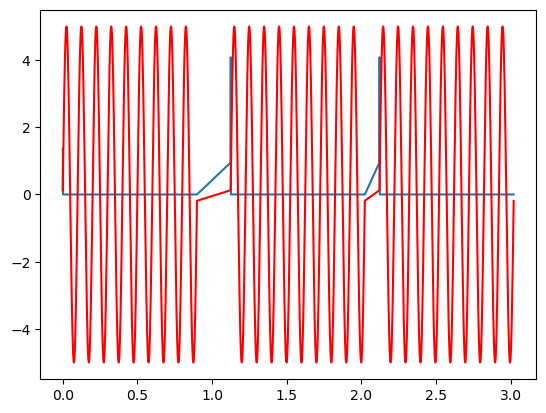

In [11]:
# print(len(daq.ai.data[0]))
# print(len(daq.ai.data[1]))
# plt.figure()
# plt.plot(daq.ai.data[0])
# plt.plot(daq.ai.data[1],'r')
aitime, aidata = daq.ai.getdata()
plt.figure()
plt.plot(aitime,aidata[0])
plt.plot(aitime,aidata[1],'r')

In [12]:
t0 = daq.ai._trigTime[0]
trigtime = [t-t0 for t in daq.ai._trigTime]
print(trigtime)

[0.0, 1.1241326332092285, 2.1210439205169678]


In [ ]:
plt.close('all')